In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\dlagu\anaconda3\envs\embed\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
class TeacherVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherVGG, self).__init__()
        
        # 입력: 1채널 (흑백)
        self.features = nn.Sequential(
            # 첫 번째 블록
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 두 번째 블록
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 세 번째 블록
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),  # 가변적인 입력 크기 처리
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
        # 가중치 초기화
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [3]:
class CompactStudentNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CompactStudentNet, self).__init__()
        
        # 특징 추출기 (더 가벼운 구조)
        self.features = nn.Sequential(
            # 첫 번째 블록
            nn.Conv2d(1, 16, 3, padding=1),  # 채널 수 감소
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # 두 번째 블록
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Depthwise Separable Convolution
            nn.Conv2d(32, 32, 3, padding=1, groups=32),  # depthwise
            nn.Conv2d(32, 64, 1),  # pointwise
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),  # 크기 감소
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Knowledge Distillation Loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        
    def forward(self, student_outputs, teacher_outputs, labels):
        # Soft Targets에 대한 KL Divergence Loss
        soft_targets = F.softmax(teacher_outputs / self.temperature, dim=1)
        student_log_softmax = F.log_softmax(student_outputs / self.temperature, dim=1)
        distillation_loss = F.kl_div(student_log_softmax, soft_targets, reduction='batchmean')
        
        # Hard Targets에 대한 Cross Entropy Loss
        student_loss = F.cross_entropy(student_outputs, labels)
        
        # 최종 Loss는 두 Loss의 가중 평균
        total_loss = (self.alpha * (self.temperature ** 2) * distillation_loss + 
                     (1 - self.alpha) * student_loss)
        return total_loss

In [4]:
class QuickDrawDataset(Dataset):
    def __init__(self, data, labels, transform=None, augment=False):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.augment = augment
    
    def __len__(self):
        return len(self.data)
    
    def add_noise(self, image, noise_factor=0.1):
        """가우시안 노이즈 추가"""
        noise = torch.randn_like(image) * noise_factor
        noisy_image = image + noise
        return torch.clamp(noisy_image, 0., 1.)

    def add_occlusion(self, image, block_size=4, num_blocks=4):
        """랜덤 위치에 사각형 영역을 0으로 설정하여 occlusion 효과 생성"""
        img = image.clone()
        h, w = img.shape[1:]
        
        for _ in range(num_blocks):
            # 랜덤 위치 선택
            x = random.randint(0, w - block_size)
            y = random.randint(0, h - block_size)
            
            # 해당 영역을 0으로 설정
            img[:, y:y+block_size, x:x+block_size] = 0
            
        return img

    def elastic_transform(self, image, alpha=500, sigma=20, random_state=None):
        """Elastic deformation for simulating natural drawing variations"""
        if random_state is None:
            random_state = np.random.RandomState(None)

        shape = image.shape[1:]
        dx = torch.tensor(random_state.rand(*shape) * 2 - 1)
        dy = torch.tensor(random_state.rand(*shape) * 2 - 1)

        # Gaussian filter
        dx = F.gaussian_blur(dx.unsqueeze(0).unsqueeze(0), kernel_size=7, sigma=sigma).squeeze()
        dy = F.gaussian_blur(dy.unsqueeze(0).unsqueeze(0), kernel_size=7, sigma=sigma).squeeze()

        # Normalize and scale
        dx = dx * alpha / (sigma * shape[0])
        dy = dy * alpha / (sigma * shape[1])

        # Create meshgrid
        x, y = torch.meshgrid(torch.arange(shape[0]), torch.arange(shape[1]))
        
        # Add displacement
        indices_x = torch.clamp(x + dx, 0, shape[0] - 1).long()
        indices_y = torch.clamp(y + dy, 0, shape[1] - 1).long()

        # Apply transformation
        transformed = image.clone()
        transformed[0] = image[0][indices_x, indices_y]
        
        return transformed

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        
        # 이미지를 텐서로 변환하고 채널 차원 추가
        image = torch.FloatTensor(image).unsqueeze(0)
        
        # Data augmentation 적용
        if self.augment:
            # 랜덤하게 augmentation 적용
            if random.random() < 0.3:  # 30% 확률로 노이즈 추가
                image = self.add_noise(image, noise_factor=0.1)
            
            if random.random() < 0.3:  # 30% 확률로 occlusion 추가
                image = self.add_occlusion(image, block_size=4, num_blocks=random.randint(1, 3))
            
            if random.random() < 0.3:  # 30% 확률로 elastic transform 적용
                image = self.elastic_transform(image, alpha=random.randint(300, 700))
            
            # 랜덤 회전 (-15도 ~ 15도)
            if random.random() < 0.3:
                angle = random.uniform(-15, 15)
                image = F.rotate(image, angle)

        # 추가 transform이 있다면 적용
        if self.transform:
            image = self.transform(image)
        
        # 레이블을 Long 타입으로 변환
        label = torch.LongTensor([label])[0]
        
        return image, label

def create_dataloaders(npz_path, batch_size=64, test_size=0.2):
    """데이터 로더 생성 함수"""
    # 데이터 로드
    data = np.load(npz_path)
    images = data['data'].astype(np.float32) / 255.0  # 정규화
    labels = data['labels']
    
    # Train/Test 분할
    num_samples = len(images)
    indices = np.random.permutation(num_samples)
    split = int(np.floor(test_size * num_samples))
    
    train_idx, test_idx = indices[split:], indices[:split]
    
    # Dataset 생성
    train_dataset = QuickDrawDataset(
        images[train_idx], 
        labels[train_idx],
        augment=True  # training set에만 augmentation 적용
    )
    
    test_dataset = QuickDrawDataset(
        images[test_idx],
        labels[test_idx],
        augment=False  # test set에는 augmentation 미적용
    )
    
    # DataLoader 생성
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, test_loader

# 데이터 로드 및 전처리 함수
def prepare_data(npz_path, test_size=0.2):
    # 데이터 로드
    data = np.load(npz_path)
    images = data['data']
    labels = data['labels']
    classes = data['classes']
    
    # 클래스별로 데이터 분리
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    for class_idx in range(len(classes)):
        # 현재 클래스의 데이터 인덱스 찾기
        class_indices = np.where(labels == class_idx)[0]
        class_images = images[class_indices]
        class_labels = labels[class_indices]
        
        # 현재 클래스의 데이터를 train/test로 분할
        X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
            class_images, class_labels, test_size=test_size, random_state=42
        )
        
        X_train.append(X_train_class)
        X_test.append(X_test_class)
        y_train.append(y_train_class)
        y_test.append(y_test_class)
    
    # 모든 클래스의 데이터 합치기
    X_train = np.concatenate(X_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # 클래스별 분포 확인
    for i in range(len(classes)):
        train_count = np.sum(y_train == i)
        test_count = np.sum(y_test == i)
        print(f"Class {classes[i]}: Train={train_count}, Test={test_count}")
    
    return X_train, X_test, y_train, y_test, classes

# 데이터 준비
X_train, X_test, y_train, y_test, classes = prepare_data('quickdraw_dataset.npz')

# 데이터 변환 정의
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomErasing(p=0.2),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))
])

# 데이터셋 생성
train_dataset = QuickDrawDataset(X_train, y_train, transform=train_transform)
test_dataset = QuickDrawDataset(X_test, y_test, transform=test_transform)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 데이터 형태 확인
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"Labels in batch: {labels}")
    break

Training set size: 40000
Test set size: 10000
Class circle: Train=4000, Test=1000
Class triangle: Train=4000, Test=1000
Class square: Train=4000, Test=1000
Class donut: Train=4000, Test=1000
Class house: Train=4000, Test=1000
Class cloud: Train=4000, Test=1000
Class lightning: Train=4000, Test=1000
Class star: Train=4000, Test=1000
Class diamond: Train=4000, Test=1000
Class banana: Train=4000, Test=1000
Batch images shape: torch.Size([64, 1, 32, 32])
Batch labels shape: torch.Size([64])
Labels in batch: tensor([5, 0, 4, 0, 1, 5, 6, 8, 3, 9, 9, 1, 7, 6, 9, 0, 9, 1, 4, 6, 1, 9, 9, 4,
        6, 6, 9, 0, 6, 5, 6, 0, 2, 9, 9, 9, 6, 3, 0, 0, 8, 9, 0, 4, 8, 4, 8, 9,
        6, 6, 6, 4, 0, 6, 5, 4, 3, 1, 1, 1, 9, 2, 5, 3])


In [5]:
def train_student(student_model, teacher_model, train_loader, test_loader, 
                 criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0
    train_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        student_model.train()
        teacher_model.eval()
        running_loss = 0.0
        
        # 학습
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                # Teacher 예측
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)
                
                # Student 학습
                student_outputs = student_model(inputs)
                loss = criterion(student_outputs, teacher_outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # 평가
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        test_accs.append(accuracy)
        
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')
        
        # 모델 저장
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
            }, 'best_student_model.pth')
        
        scheduler.step(accuracy)
    
    return train_losses, test_accs

# 모델, 손실 함수, 최적화기 설정
student_model = CompactStudentNet(num_classes=len(classes)).to(device)
teacher_model = TeacherVGG(num_classes=len(classes)).to(device)

# Teacher 모델 로드
teacher_checkpoint = torch.load('best_teacher_model.pth', map_location=device)
teacher_model.load_state_dict(teacher_checkpoint['model_state_dict'])
teacher_model.eval()

criterion = DistillationLoss(temperature=3.0, alpha=0.5)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                               factor=0.5, patience=5)

# 학습 실행
train_losses, test_accs = train_student(student_model, teacher_model,
                                      train_loader, test_loader,
                                      criterion, optimizer, scheduler)

Epoch 1/10: 100%|██████████| 625/625 [00:29<00:00, 20.86it/s, loss=1.4976]


Epoch 1: Loss = 2.7113, Accuracy = 91.69%


Epoch 2/10: 100%|██████████| 625/625 [00:27<00:00, 22.81it/s, loss=1.4267]


Epoch 2: Loss = 1.0777, Accuracy = 92.98%


Epoch 3/10: 100%|██████████| 625/625 [00:27<00:00, 22.91it/s, loss=0.7691]


Epoch 3: Loss = 0.8343, Accuracy = 94.27%


Epoch 4/10: 100%|██████████| 625/625 [00:27<00:00, 22.71it/s, loss=0.7702]


Epoch 4: Loss = 0.7246, Accuracy = 94.76%


Epoch 5/10: 100%|██████████| 625/625 [00:28<00:00, 21.86it/s, loss=0.5521]


Epoch 5: Loss = 0.6583, Accuracy = 94.63%


Epoch 6/10: 100%|██████████| 625/625 [00:30<00:00, 20.70it/s, loss=0.5700]


Epoch 6: Loss = 0.6080, Accuracy = 94.86%


Epoch 7/10: 100%|██████████| 625/625 [00:33<00:00, 18.63it/s, loss=0.5068]


Epoch 7: Loss = 0.5752, Accuracy = 94.86%


Epoch 8/10: 100%|██████████| 625/625 [00:38<00:00, 16.22it/s, loss=0.4429]


Epoch 8: Loss = 0.5363, Accuracy = 94.88%


Epoch 9/10: 100%|██████████| 625/625 [00:30<00:00, 20.66it/s, loss=0.4720]


Epoch 9: Loss = 0.5233, Accuracy = 95.44%


Epoch 10/10: 100%|██████████| 625/625 [00:29<00:00, 20.91it/s, loss=0.4609]


Epoch 10: Loss = 0.5004, Accuracy = 95.35%



Evaluating final model performance:
Accuracy of circle: 93.00%
Accuracy of triangle: 97.40%
Accuracy of square: 94.90%
Accuracy of donut: 97.20%
Accuracy of house: 98.50%
Accuracy of cloud: 96.90%
Accuracy of lightning: 89.80%
Accuracy of star: 95.20%
Accuracy of diamond: 94.50%
Accuracy of banana: 96.10%


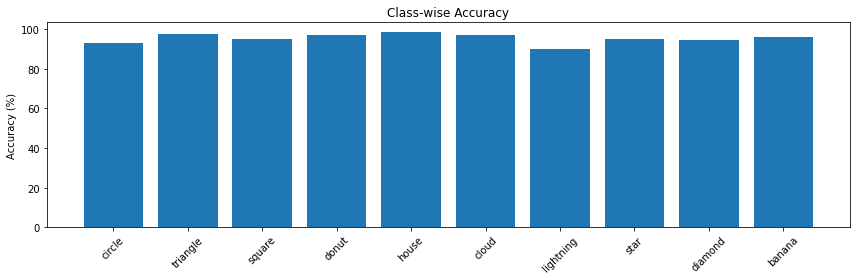


Sample predictions:


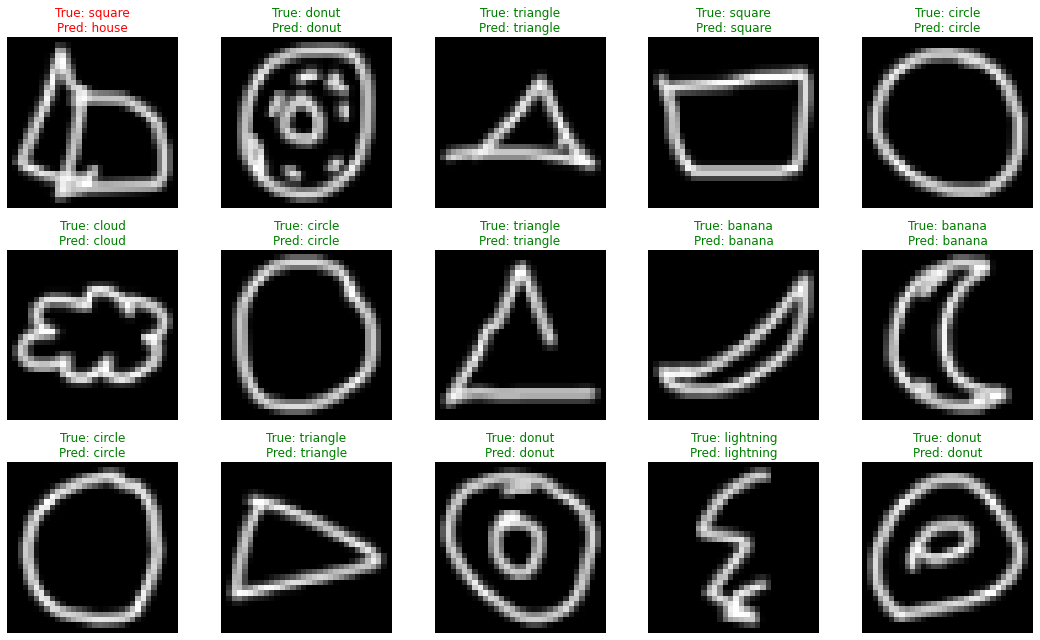

In [6]:
def visualize_predictions(model, test_loader, classes, num_samples=10):
    """
    테스트 세트에서 무작위로 샘플을 선택하여 예측 결과를 시각화
    """
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    # 데이터 수집
    with torch.no_grad():
        for images, labels in test_loader:
            all_images.extend(images.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            outputs = model(images.to(device))
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
    
    # 무작위 샘플 선택
    total_samples = len(all_images)
    selected_indices = np.random.choice(total_samples, min(num_samples, total_samples), replace=False)
    
    # 시각화
    num_cols = 5
    num_rows = (num_samples + num_cols - 1) // num_cols
    plt.figure(figsize=(15, 3 * num_rows))
    
    for idx, sample_idx in enumerate(selected_indices):
        image = all_images[sample_idx].squeeze()
        true_label = classes[all_labels[sample_idx]]
        pred_label = classes[all_preds[sample_idx]]
        
        plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image, cmap='gray')
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def train_student(student_model, teacher_model, train_loader, test_loader, 
                 criterion, optimizer, scheduler, num_epochs=50):
    best_acc = 0
    train_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        student_model.train()
        teacher_model.eval()
        running_loss = 0.0
        
        # 학습
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                # Teacher 예측
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)
                
                # Student 학습
                student_outputs = student_model(inputs)
                loss = criterion(student_outputs, teacher_outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # 평가
        student_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100. * correct / total
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        test_accs.append(accuracy)
        
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%')
        
        # 매 5 에포크마다 예측 결과 시각화
        if (epoch + 1) % 5 == 0:
            print("\nVisualization of current predictions:")
            visualize_predictions(student_model, test_loader, classes)
            plt.savefig(f'predictions_epoch_{epoch+1}.png')
        
        # 모델 저장
        if accuracy > best_acc:
            best_acc = accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
            }, 'best_student_model.pth')
            
            # 베스트 모델의 예측 결과 시각화
            print("\nVisualization of best model predictions:")
            visualize_predictions(student_model, test_loader, classes)
            plt.savefig('best_model_predictions.png')
        
        scheduler.step(accuracy)
    
    return train_losses, test_accs

def evaluate_model(model, test_loader, classes):
    """
    모델의 성능을 자세히 평가하고 시각화
    """
    model.eval()
    all_preds = []
    all_labels = []
    class_correct = [0] * len(classes)
    class_total = [0] * len(classes)
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # 클래스별 정확도 계산
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 클래스별 정확도 출력 및 시각화
    plt.figure(figsize=(12, 4))
    accuracies = []
    for i in range(len(classes)):
        acc = 100 * class_correct[i] / class_total[i]
        accuracies.append(acc)
        print(f'Accuracy of {classes[i]}: {acc:.2f}%')
    
    plt.bar(classes, accuracies)
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy (%)')
    plt.tight_layout()
    plt.show()
    
    # 예측 샘플 시각화
    print("\nSample predictions:")
    visualize_predictions(model, test_loader, classes, num_samples=15)

# 학습 완료 후 평가
print("\nEvaluating final model performance:")
evaluate_model(student_model, test_loader, classes)